# Capstone Project: Deutsche-Boerse Dataset
Sizhe Ren, Qiao Lin, Tian Xia

We are choosing Deutsche-Boerse open dataset available on Central Europe AWS bucket (I am not sure how would that affect calculation performance). I started to get a hint of stock markets when my mother invested in stocks in 2009. The price of stocks varied randomly but seemed to follow a certain pattern, and people who believed in technical analysis do think that they can find the thread from this complicated puzzle. Finding this pattern gradually becomes my interest through the course of my undergraduate education. Now I am pursuing a Financial Engineering master’s degree and to a large degree, financial engineering is interested in analyzing the capital market in a quantitative way. This dataset is about the equity market in Germany including stocks and ETFs (exchange-traded funds). More information about boerse frankfurt market can be found at https://www.boerse-frankfurt.de/en. This is the stock market traded at Germany, Frankfurt. 

The content in this dataset is very straightforward and they can be divided into several categories: categorical data specifying tickers, security types and security descriptions; floating numeric data specifying prices at various points and trading volume.

The open dataset can be found with descriptions at https://github.com/Deutsche-Boerse/dbg-pds
Our work is referring to this AWS sample notebook at https://github.com/aws-samples/amazon-sagemaker-stock-prediction

Our actual architecture (Obtaining Data Second Try)
<img src="tools-diagram.png">

## 1. Obtaining Data (First Try)

We start by finding what files are available for a particular date by running an `aws s3 ls` on the PDS AWS S3 bucket.
Note the `--no-sign-request` parameter. This means you don't need to have an AWS key or account for this to work.

In [4]:
import boto3
import botocore
import pandas as pd
from IPython.display import display, Markdown

s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

create bucket:

In [5]:
def create_bucket(bucket):
    import logging

    try:
        s3.create_bucket(Bucket=bucket)
    except botocore.exceptions.ClientError as e:
        logging.error(e)
        return 'Bucket ' + bucket + ' could not be created.'
    return 'Created or already exists ' + bucket + ' bucket.'

In [6]:
create_bucket('open-data-stock')

'Created or already exists open-data-stock bucket.'

In [7]:
def list_buckets(match=''):
    response = s3.list_buckets()
    if match:
        print(f'Existing buckets containing "{match}" string:')
    else:
        print('All existing buckets:')
    for bucket in response['Buckets']:
        if match:
            if match in bucket["Name"]:
                print(f'  {bucket["Name"]}')
                

In [14]:
def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

In [ ]:
list_bucket_contents(bucket='deutsche-boerse-xetra-pds', match='2018', size_mb=250)

As it comes to here, we are having big trouble to transfer data into S3 bucket. 
Error message as the following: 
ClientError: An error occurred (AccessDenied) when calling the ListObjects operation: Access Denied
I later changed the access requirement of the s3 bucket, which however did not work as well. I am personally very confused why New York taxi data can be accessed perfectly fine, but this dataset does not work. I guess the region of the dataset matters, as this dataset is in the Central Europe Region

## 1'. Obtaining Data (Second Try)

This time, we are trying to directly download data from open registry to sagemaker.
Now we direct the open dataset to our Sagemaker directory. 

In [5]:
date = '2018-03-26'
! aws s3 ls s3://deutsche-boerse-xetra-pds/{date}/ --no-sign-request
! aws s3 sync s3://deutsche-boerse-xetra-pds/{date} /home/ec2-user/SageMaker/{date} --no-sign-request
! ls /home/ec2-user/SageMaker/{date}

2018-04-04 18:07:23        136 2018-03-26_BINS_XETR00.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR01.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR02.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR03.csv
2018-04-04 18:07:23        251 2018-03-26_BINS_XETR04.csv
2018-04-04 18:07:24        136 2018-03-26_BINS_XETR05.csv
2018-04-04 18:07:23        136 2018-03-26_BINS_XETR06.csv
2018-04-04 18:07:24     999016 2018-03-26_BINS_XETR07.csv
2018-04-04 18:07:24     882055 2018-03-26_BINS_XETR08.csv
2018-04-04 18:07:24     861920 2018-03-26_BINS_XETR09.csv
2018-04-04 18:07:24     816397 2018-03-26_BINS_XETR10.csv
2018-04-04 18:07:24     793111 2018-03-26_BINS_XETR11.csv
2018-04-04 18:07:24     848602 2018-03-26_BINS_XETR12.csv
2018-04-04 18:07:24    1094364 2018-03-26_BINS_XETR13.csv
2018-04-04 18:07:24    1260469 2018-03-26_BINS_XETR14.csv
2018-04-04 18:07:24     870234 2018-03-26_BINS_XETR15.csv
2018-04-04 18:07:26        136 2018-03-26_BINS_XETR16.csv
2018-04-04 18:

In [6]:
# Introduce imports which we will use next
import pandas as pd
import numpy as np
import glob, os
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

Load the files from a date directory

In [7]:
def load_csv_dir(data_dir):
    return pd.concat(map(pd.read_csv, glob.glob(os.path.join(data_dir, '*.csv'))))

data_dir = '/home/ec2-user/SageMaker/%s/' % date
print("Loading from {}".format(data_dir))
unprococessed_df = load_csv_dir(data_dir)

Loading from /home/ec2-user/SageMaker/2018-03-26/


Introduce a new column called CalcDateTime that is a timestamp calculated from the date and time string columns

In [8]:
time_fmt = "%H:%M"

def convert_time(time):
    return datetime.strptime(time, time_fmt)

def convert_dt(date, time):
    return datetime.strptime(date + ' ' + time, '%Y-%m-%d %H:%M')

unprococessed_df["CalcTime"] = unprococessed_df.apply(lambda row: convert_time(row['Time']), axis=1)
unprococessed_df["CalcDateTime"] = unprococessed_df.apply(lambda row: convert_dt(row['Date'], row['Time']), axis=1)

 #Only keep common stock securities for analysis
only_common_stock = unprococessed_df[unprococessed_df.SecurityType == 'Common stock']
print("Common stock: {}, Other: {}".format(only_common_stock.count()[0], unprococessed_df[unprococessed_df.SecurityType != 'Common stock'].count()[0]))


# Keep only data points with trades between the opening and closing hours
opening_hours = datetime.strptime("08:00", time_fmt)
closing_hours = datetime.strptime("20:00", time_fmt)

cleaned_common_stock = only_common_stock[(only_common_stock.TradedVolume > 0) & \
                  (only_common_stock.CalcTime >= opening_hours) & \
                  (only_common_stock.CalcTime <= closing_hours)]

Common stock: 59550, Other: 11284


In [9]:
cleaned_common_stock.head(30)

,ISIN,Mnemonic,SecurityDesc,SecurityType,Currency,SecurityID,Date,Time,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,CalcTime,CalcDateTime
0,AT0000A0E9W5,SANT,S+T AG (Z.REG.MK.Z.)O.N.,Common stock,EUR,2504159,2018-03-26,14:00,21.340,21.360,21.340,21.360,568,4,1900-01-01 14:00:00,2018-03-26 14:00:00
1,CA4969024047,KIN2,KINROSS GOLD CORP.,Common stock,EUR,2504199,2018-03-26,14:00,3.150,3.150,3.150,3.150,68,1,1900-01-01 14:00:00,2018-03-26 14:00:00
2,CH0012032113,RHO,ROCHE HLDG AG INH. SF 1,Common stock,EUR,2504219,2018-03-26,14:00,186.800,186.800,186.800,186.800,1,1,1900-01-01 14:00:00,2018-03-26 14:00:00
3,CH0038863350,NESR,"NESTLE NAM. SF-,10",Common stock,EUR,2504245,2018-03-26,14:00,62.860,62.880,62.860,62.880,165,2,1900-01-01 14:00:00,2018-03-26 14:00:00
7,DE000A0CAYB2,WIN,DIEBOLD NIXDORF INH.O.N.,Common stock,EUR,2504286,2018-03-26,14:00,66.300,66.300,66.300,66.300,17,1,1900-01-01 14:00:00,2018-03-26 14:00:00
8,DE000A0DJ6J9,S92,SMA SOLAR TECHNOL.AG,Common stock,EUR,2504287,2018-03-26,14:00,55.850,55.850,55.850,55.850,96,1,1900-01-01 14:00:00,2018-03-26 14:00:00
9,DE000A0D6554,NDX1,NORDEX SE O.N.,Common stock,EUR,2504290,2018-03-26,14:00,8.250,8.252,8.250,8.252,1227,4,1900-01-01 14:00:00,2018-03-26 14:00:00
10,DE000A0D9PT0,MTX,MTU AERO ENGINES NA O.N.,Common stock,EUR,2504297,2018-03-26,14:00,134.100,134.100,134.100,134.100,501,6,1900-01-01 14:00:00,2018-03-26 14:00:00
11,DE000A0HN5C6,DWNI,DEUTSCHE WOHNEN SE INH,Common stock,EUR,2504314,2018-03-26,14:00,36.400,36.420,36.390,36.420,1068,7,1900-01-01 14:00:00,2018-03-26 14:00:00
13,DE000A0JQ5U3,M5Z,MANZ AG,Common stock,EUR,2504345,2018-03-26,14:00,30.000,30.000,30.000,30.000,700,1,1900-01-01 14:00:00,2018-03-26 14:00:00


Now we are able to play with the data! Hurrayyy!!!

## 2. Plotting Data
Now we are going to define a method to conveniently plot stock data

In [10]:
#mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs
def timeseries_plot(df, mnemonics, metrics):
    ax = None
    for mnemonic in mnemonics:
        for metric in metrics:
            selected = df[df.Mnemonic == mnemonic][['CalcDateTime', metric]].copy()
            selected.index = selected['CalcDateTime']
            selected = selected.sort_index()
            del selected['CalcDateTime']
            ax = selected.plot( ax = ax)
    
#timeseries_plot(cleaned_common_stock, ['SAP'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) 

Here are some examples to plot SAP, BMW, and other stocks with various financial metrics

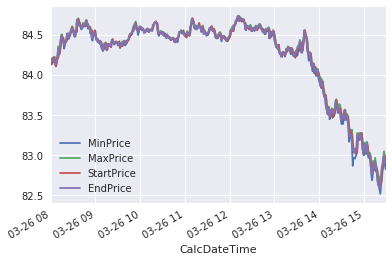

In [11]:
timeseries_plot(cleaned_common_stock, ['SAP'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice']) 

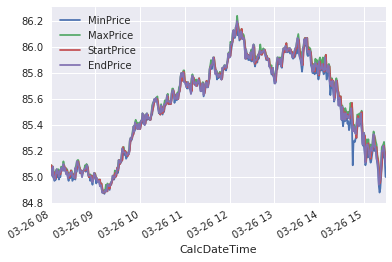

In [12]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice'])

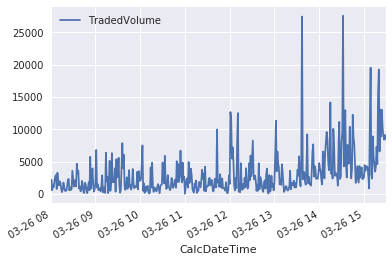

In [13]:
timeseries_plot(cleaned_common_stock, ['BMW'], ['TradedVolume'])

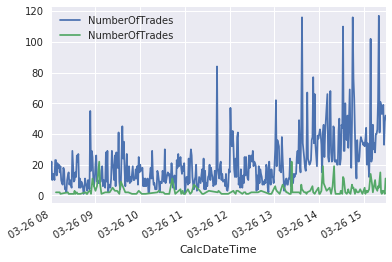

In [14]:
timeseries_plot(cleaned_common_stock, ['BMW', 'NOEJ'], ['NumberOfTrades'])

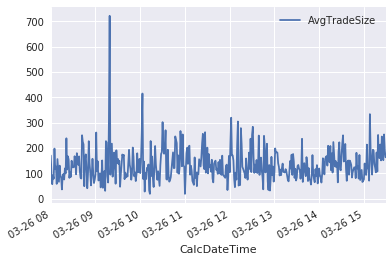

In [15]:
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
selected['AvgTradeSize'] = selected['TradedVolume'] / (0.1 + selected['NumberOfTrades'])
selected[['AvgTradeSize']].plot()

## 2’. Plotting data in another time interval 

Reset the time interval to be 15mins to have a closer look at the data

In [16]:
df = cleaned_common_stock
mnemonic = 'BMW'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
interval = '15Min'
resampled1 = pd.DataFrame({
    'EndPrice': selected['EndPrice'].resample(interval).last(),
    'StartPrice': selected['StartPrice'].resample(interval).first(),    
    'MinPrice': selected['MinPrice'].resample(interval).min(),  
    'MaxPrice': selected['MaxPrice'].resample(interval).max(),   
})
mnemonic = 'NOEJ'
selected = df[df.Mnemonic == mnemonic].copy()
selected.index = selected['CalcDateTime']
selected = selected.sort_index()
interval = '15Min'
resampled2 = pd.DataFrame({
    'EndPrice': selected['EndPrice'].resample(interval).last(),
    'StartPrice': selected['StartPrice'].resample(interval).first(),    
    'MinPrice': selected['MinPrice'].resample(interval).min(),  
    'MaxPrice': selected['MaxPrice'].resample(interval).max(),   
})

## 3. Small Exercise: Apply the Data to a Real Financial Hypothesis

We want to confirm the financial hypothesis that liquidity necessarily creates price homogeneity: That is, whichever stock is traded more frequently necessarily has more stability in price than whichever stock that is traded less frequently.
We want to take the number of trades to be our measure of trade frequency, and the daily price range as a measure of stability.
Our hypothesis is that the stock that has more number of trades has less daily price deviations. 
In this case, BMW will have less daily price deviations than NOEJ

In this case, BMW will have less daily price deviations than NOEJ
As shown here, the NOEJ is much less liquid than BMW. Blue representing BMW and Green representing NOEJ

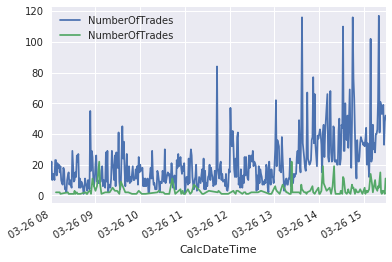

In [31]:
timeseries_plot(cleaned_common_stock, ['BMW', 'NOEJ'], ['NumberOfTrades'])

We take the individual percentage changes and take the norm measurement of them. The reason for taking the norm is to avoid accounting for negative changes, thus we can compare changes into both the positive and negative directions at once.

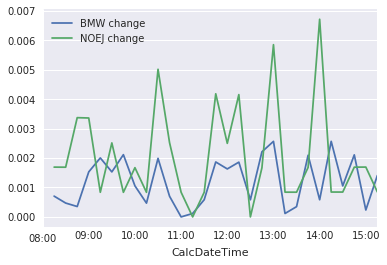

In [57]:
resampled1['PctChange'] = resampled1['EndPrice'].pct_change()
resampled1['BMW change'] = (resampled1['PctChange']**2)**0.5

resampled2['PctChange'] = resampled2['EndPrice'].pct_change()
resampled1['NOEJ change'] = (resampled2['PctChange']**2)**0.5
resampled1[['BMW change', 'NOEJ change']].plot()


We could observe that BMW has lower price change in magnitude.
Then I also add calculation of standard deviation matrics to confirm our finding.

BMW price standard deviation

In [62]:
resampled1['EndPrice'].std(axis = 0, skipna = True)

0.3655178974186256

NOEJ price standard deviation

In [64]:
resampled2['EndPrice'].std(axis = 0, skipna = True)

0.3226194869088559

A little bit surprised right? BMW's intraday price standard deviation is larger than NOEJ's. But it makes sense. As BMW has much more trades, each trade would probably drive the price up and down more quickly. It also shows that data range and standard deviation might not agree.

## Deployment and Productionization
As we learned in the lab, I will download the python script as .ipynb format and then convert it into html format using nbconvert command. Due to the time limit, we are not adding much to it aesthetics wise, but we think this post has really rich content to play with the big data and visualize it.  

## Next steps: dense neural nets and convolutional neural nets
As the time is limited, we cannot implement the neural network part; however, our work here show you some quick tricks to play with the data and extract some interesting information from the big dataset. Moreover, our work here prepares for the later neural network algorithm.

Observe that our indicator metric is a linear combination of features, which can be followed by a non-linear thresholding operation. Moreover, we have actually 3 indicators. The distances we computed were computed between lines, but they could be computed between data points.

This is an ideal situation for a two-layer neural network with one hidden dense layer.
In the notebooks to follow we will show that such indicators (features) can be synthesized automatically.

Another observation is that we can resample data into 1 minute, 2 minute, 15 minutes, etc.
For each type of resampling one can compute the same types of features. Indeed, such operations are common for convolutional neural networks 